**Author**: [Aakash Kumar Nain](https:twitter.com/A_K_Nain) <br/>
**Date Created**: 2022/08/22 <br/>
**Last Modified**: 2022/09/02 <br/>
**Description**: A deeper dive into DDPMs <br/>


In the last [notebook](https://github.com/AakashKumarNain/diffusion_models/blob/main/notebooks/all_you_need_to_know_about_gaussian.ipynb), we discussed about Gaussian Distribution, its applications in context of diffusion models, and the forward process in diffusion models. Let's revisit the forward process equation and the corresponding code that we saw in the last notebook.

In [1]:
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

seed = 1234
np.random.seed(seed)
plt.style.use('ggplot')

%config IPCompleter.use_jedi = False
%config InlineBackend.figure_format='png'
%matplotlib inline

# 1. The Forward Process

$$
q(x_{1:T}\vert x_{0})
:= \prod_{t=1}^{T}q(x_{t}\vert x_{t-1})
:=\prod_{t=1}^{T}\mathcal{N}(x_{t};\sqrt{1-\beta_{t}} x_{t-1},\ \beta_{t}\bf I) \tag{1}
$$

As a refresher, $q(x_{0:T})$ is known as the **forward distribution** and $q(x_{t}\vert x_{t-1}$ is referred as **forward diffusion kernel**

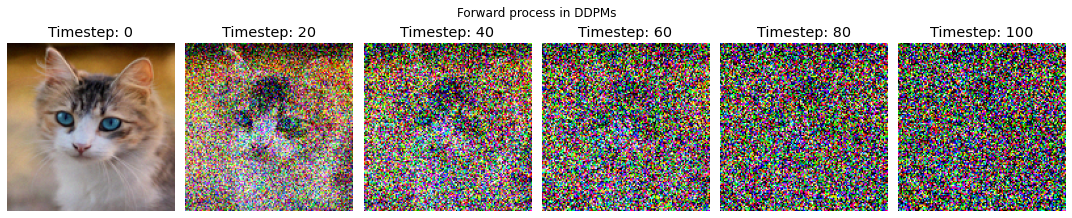

In [2]:
def forward_process_ddpms(img_t_minus_1, beta, t):
    """Implements the forward process of a DDPM model.
    
    Args:
        img_t_minus_1: Image at the previous timestep (t - 1)
        beta: Scheduled Variance
        t: Current timestep
    Returns:
        Image obtained at current timestep
    """
    
    # 1. Obtain beta_t. Reshape it to have the same number of
    # dimensions as our image array
    beta_t = beta[t].reshape(-1, 1, 1)
    
    # 2. Calculate mean and variance
    mu = np.sqrt((1.0 - beta_t)) * img_t_minus_1
    sigma = np.sqrt(beta_t)
    
    # 3. Obtain image at timestep t using equation (15)
    img_t = mu + sigma * np.random.randn(*img_t_minus_1.shape)
    return img_t


# Let's check if ourforward process function is
# doing what it is supposed to do on a sample image

# 1. Load image using PIL (or any other library that you prefer)
img = Image.open("../images/cat.jpg")

# 2. Resize the image to desired dimensions
IMG_SIZE = (128, 128)
img = img.resize(size=IMG_SIZE)

# 3. Define number of timesteps
timesteps = 100

# 4. Generate beta (variance schedule)
beta_start = 0.0001
beta_end = 0.05
beta = np.linspace(beta_start, beta_end, num=timesteps, dtype=np.float32)


processed_images = []
img_t = np.asarray(img.copy(), dtype=np.float32) / 255.

# 5. Run the forward process to obtain img after t timesteps
for t in range(timesteps):
    img_t = forward_process_ddpms(img_t_minus_1=img_t, beta=beta, t=t)
    if t%20==0 or t==timesteps - 1:
        sample = (img_t.clip(0, 1) * 255.0).astype(np.uint8)
        processed_images.append(sample)

# 6. Plot and see samples at different timesteps
_, ax = plt.subplots(1, len(processed_images), figsize=(15, 6))

for i, sample in enumerate(processed_images):
    ax[i].imshow(sample)
    ax[i].set_title(f"Timestep: {i*20}")
    ax[i].axis("off")
    ax[i].grid(False)

plt.suptitle("Forward process in DDPMs", y=0.75)
plt.tight_layout()
plt.axis("off")
plt.savefig("../plots/forward_process.png", pad_inches=0, bbox_inches='tight')
plt.show()
plt.close()

Can you spot a major problem with the above equation? (Hint: Check the loop)

Don't worry if you didn't get it. Look at the above code closely. Forget everything from the modelling perspective except for the forward pass. You will notice that to obtain a noisy sample, say at timestep `t`, we need to iterate from `t0` to `t-1`. Why? Because the sample obtained at each timestep is conditioned on the samples from the previous timesteps. 

That's not efficient. What if there are 1000 steps and you want to sample the `999th` timestep? You will iterate the whole loop, simulating the entire Markov Chain. Now that we know the problem, we should think about how we can do better.



# 2. Reparameterization

We know that sum of the independent Gaussians is still a Gaussian. We can leverage this fact to sample from an arbitrary forward step. All we need to do is apply the `reparameterization` trick.

Let &nbsp; $\alpha_{t} = 1 - \beta_{t},$ &nbsp; and  &nbsp; $\bar{\alpha}_{t} = \prod_{i=1}^T \alpha_{i}$

From equation (1) we know that:


$$
q(x_{1:T}\vert x_{0}) := \prod_{t=1}^{T}q(x_{t}\vert x_{t-1}) :=\prod_{t=1}^{T}\mathcal{N}(x_{t};\sqrt{1-\beta_{t}} x_{t-1},\ \beta_{t} \bf{I}) \\
$$

$$
\text{or} \ \ q(x_{t}\vert x_{t-1}) = \mathcal{N}(x_{t};\sqrt{1-\beta_{t}} x_{t-1},\ \beta_{t} \bf{I})
$$

We can obtain the sample at timestep `t` as:

$$
x_{t} = \sqrt{1 - \beta_{t}} x_{t-1} +  \sqrt{\beta_{t}}\epsilon_{t-1}; \ \ \text where \ \  \epsilon_{t-1} \sim \mathcal{N}(0, \bf{I})
$$

Replacing $\beta$ with $\alpha$ in the above equation we can obtain sample at timestep `t` as:

$$
\begin{align*}
x_{t} &= \sqrt{\alpha_{t}} x_{t-1} + \sqrt{1 - \alpha_{t}}\epsilon_{t-1} \\
\Rightarrow x_{t} &= 
\sqrt{\alpha_{t}} \ \ \underbrace{(\sqrt{\alpha_{t-1}} x_{t-2} + \sqrt{1 - \alpha_{t-1}}\epsilon_{t-2})}_{\text{( Expanding } x_{t-1})} + 
\sqrt{1 - \alpha_{t}}\epsilon_{t-1} \\ \\
&= \sqrt{\alpha_{t} \alpha_{t-1}} x_{t-2} + 
\underbrace{\sqrt{\alpha_{t}(1 - \alpha_{t-1})}\epsilon_{t-2}}_{\text{RV1}} + 
\underbrace{\sqrt{1 - \alpha_{t}}\epsilon_{t-1}}_{\text{RV2}} \\
\end{align*}
$$

The two terms namely RV1, and RV2 on RHS in the above equation are two random variables distributed **normally** with a mean of zero and variances $\alpha_{t}(1 - \alpha_{t-1})\ $, and $(1 - \alpha_{t})$ respectively. 

In the last [lesson](https://github.com/AakashKumarNain/diffusion_models/blob/main/notebooks/all_you_need_to_know_about_gaussian.ipynb) we learned that if we have two Gaussian distributions with mean values $\mu_{1} , \mu_{2}$ and variances $\sigma_{1}^2 , \sigma_{2}^2$ respectively, then the sum of these two random variables is equivaluent to another random variable with a normal distribution $\mathcal{N}(\mu_{1} + \mu_{2}, \sigma_{1}^2 +\sigma_{2}^2)$. Applying this to the above equation yields:

$$
\begin{align*}
\Rightarrow x_{t} &= 
\sqrt{\alpha_{t} \alpha_{t-1}} x_{t-2} + 
\sqrt{\alpha_{t}(1 - \alpha_{t-1}) + 
(1 - \alpha_{t})}\bar{z}_{t-2} & \bar{z}_{t-2} \ \text {is the merged Gaussian} \\
&= \sqrt{\alpha_{t} \alpha_{t-1}} x_{t-2} + 
\sqrt{1 - \alpha_{t} \alpha_{t-1}}\bar{z}_{t-2} \\
&= \ \ ... \\
\Rightarrow x_{t}&= \sqrt{\bar{\alpha_{t}}} x_{0} + 
\sqrt{1 - \bar{\alpha_{t}}}\epsilon \ \  \ \text{ (since } \
\ \bar{\alpha}_{t} = \prod_{i=1}^T \alpha_{i})
\end{align*}
$$

From above, we can say that:

$$
q(x_{t}\vert x_{0}) = \mathcal{N}(x_{t};\sqrt{\bar{\alpha_{t}}} x_{0},\ (1 - \bar{\alpha_{t}}) \ \bf{I}) \tag {2}
$$

Ha! The above equation is nice.Given the original image, we can now sample at any arbitrary timestep without simulating the entire Markov chain till that step. Before coding it up, let's recap of what we did and achieve:

1. We figured out that in the original formulation, we need to simulate the Markov chain to the step for which we want to sample.
2. We reparameterized $\beta$ in terms of $\alpha$
3. The above reparameterization leads to an equation where we can sample at any arbitrary timestep 


Let's code it and compare the results with the previous results 

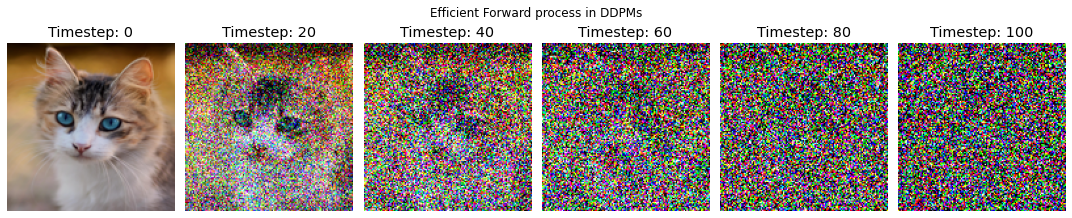

In [3]:
def forward_process_ddpms_v2(orig_img, alpha_bar, t):
    """Implements the efficient forward process of a DDPM model.
    
    Args:
        orig_img: Image at timestep t=0
        alpha_bar: The reparameterized version of beta
        t: Current timestep
    Returns:
        Image obtained at current timestep
    """
    
    # 1. Obtain beta_t. Reshape it to have the same number of
    # dimensions as our image array
    alpha_bar_t = alpha_bar[t].reshape(-1, 1, 1)
    
    # 2. Calculate mean and variance
    mu = np.sqrt(alpha_bar_t) * orig_img
    sigma = np.sqrt(1.0 - alpha_bar_t)
    
    # 3. Obtain image at timestep t
    img_t = mu + sigma * np.random.randn(*orig_img.shape)
    return img_t



# 1. Define alpha and alpha_bar
alpha = 1.0 - beta
alpha_bar = np.cumprod(alpha)


processed_images = [img] # Image at 0th step
orig_img = np.asarray(img.copy(), dtype=np.float32) / 255.


# 2. Run the forward pass for specific timesteps
# We will use the timesteps we used in previous visualizations
specific_timesteps = [19, 39, 59, 79, 99]
for step in specific_timesteps:
    img_t = forward_process_ddpms_v2(orig_img, alpha_bar, step)
    img_t = (img_t.clip(0, 1) * 255.0).astype(np.uint8)
    processed_images.append(img_t)

    
# 3. Plot and see samples at different timesteps
_, ax = plt.subplots(1, len(processed_images), figsize=(15, 6))

for i, sample in enumerate(processed_images):
    ax[i].imshow(sample)
    ax[i].set_title(f"Timestep: {i*20}")
    ax[i].axis("off")
    ax[i].grid(False)

plt.suptitle("Efficient Forward process in DDPMs", y=0.75)
plt.axis("off")
plt.tight_layout()
plt.savefig("../plots/efficient_forward_process.png",
            pad_inches=0,
            bbox_inches='tight'
           )
plt.show()
plt.close()

Now that we are aware of everything involved in the forward process, we need to figure out how are we going to generate image from the noise we got at the end of the forward process. 


# 3. The Reverse Process

We should end up with a pure noise distribution by the end of the forward process, given we set the variance schedule appropriately i.e. the distribution we will end up with will be $\sim \mathcal{N}(x_{T}; 0,I)$. For the reverse process, we will start with noise, and will try to undo the noise at each timestep to obtain back the original image. We can write this process as:

$$
p_{\theta}(x_{0:T}) 
:= p(x_{T}) \prod_{t=1}^T p_{\theta}(x_{t-1} | x_{t}) 
:= p(x_{T}) \prod_{t=1}^T \mathcal{N}(x_{t-1}; \mu_{\theta}(x_{t}, t), \Sigma_{\theta}(x_{t}, t)) \tag{3}
$$

where the parameters of the multivariate Gaussian are time-dependent and are to be learned.

A few things to note:

1. $p(x_{0:T})$ is the **reverse distribution** and $p(x_{t-1} | x_{t})$ is known as the **reverse diffusion kernel**
2. $\mu_{\theta}(x_{t}, t), \Sigma_{\theta}(x_{t}$ are the learnable parameters of the reverse distribution
3. The forward process can be seen as pushing the sample off the data mainfold, turning it into noise. The reverse process can be seen as pushing the sample back to the manifold by removing the noise. (Words taken from Ari Seff's [tutorial](https://www.youtube.com/watch?v=fbLgFrlTnGU) because I don't think there is any better way to put it.)
4. $p(x_{T})$ is nothing but $q(x_{T})$ i.e. the point where the forward process ends is the starting point of the reverse process.
5. There can be `n` number of pathways to arrive at a sample $p_{\theta}(x_{0})$ starting from a noise sample. To obtain $p_{\theta}(x_{0})$, we would then be required to integrate over all the possible pathways i.e. $p_{\theta}(x_{0}) = \int p_{\theta}(x_{0:T})dx_{1:T}$
6. Calculating density like in the above step is intractable. A neural network is sufficient to predict the mean $\mu_{\theta}$ and the diagonal covariance matrix $\Sigma_{\theta}$ for the reverse process as shown below in the equation, but we would also be required to frame our objectve function differently



# 4. The Training Objective

Let's write down all the equations we saw for the reverse process, again before we move to the discussion on training objective. 

$$
\begin{align*}
p_{\theta}(x_{0}) &= \int p_{\theta}(x_{0:T})dx_{1:T} \tag{4} \\
p_{\theta}(x_{t-1}|x_{t}) &:= \mathcal{N}(x_{t-1}; \mu_{\theta}(x_{t}, t), \Sigma_{\theta}(x_{t}, t)) \tag{5}
\end{align*}
$$

If eq.*(4)* is intractable, then how do we frame our objective function? 

If you have worked with other types of generative models before, then you might have seen something like equation eq.*(4)* in other types of generative models. But where? The answer is **Variational AutoEncoder**(VAE for short). If we treat $x_{0}$ as **observed variable** and $x_{1:T}$ as **latent variables**, then we have a setup similar to a VAE.

Similarities:
1. The forward process can be seen as the equivalent of the encoder in a VAE converting data to latents
2. The reverse process can be seen as the equivalent of the decoder in a VAE producing data from latents
3. Given that the above two hold, we can maximize the lower bound (Check out this [post](https://lilianweng.github.io/posts/2018-08-12-vae/#loss-function-elbo) if you need a referesher on ELBO)

Differences:
1. Unlike a VAE where the encoder is jointly trained with the decoder, the forward process in DDPMs is fixed. Only the reverse part is trainable
2. Unlike in VAEs, the latents in DDPMs have the same dimensionality as the observed variable
3. Variation lower bound or Evidence lower bound (ELBO for short), in the case of DDPMs, is a sum of losses at each time step `t`, $L = L_{0} + L_{1} + ... + L_{T}$ <br/> 

![vae_ddpm](../images/vae_ddpm.jpg)

First, let's write down the lower bound we see in a VAE here. Let's say **x** is an observed variable, and **z** is the latent variable (in context of a VAE). It is known that:

$$
\begin{align*}
&\text{log}\ p_{\theta}(x) \ge \text{variational lower bound} \\
\Rightarrow &\text{log}\ p_{\theta}(x) \ge \mathbb{E}_{q_{\phi}(z|x)}[\text{log}\ p_{\theta}(x|z)] \ - \ D_{KL}(q_{\phi}(z|x) \parallel	p_{\theta}(z)) \tag{6}
\end{align*}
$$


As discussed earlier, when it comes to diffusion models, we can treat $x_{0}$ as the observed variable, and $x_{1:T}$ as the latent varaibles. Substituting these in equation *(6)* yields:

$$
\begin{align*}
\text{log}\ p_{\theta}(x_{0}) &\ge \mathbb{E}_{q(x_{1:T}|x_{0})}[\text{log}\ p_{\theta}(x_{0}|x_{1:T})] \ - \ \underbrace{D_{KL}(q(x_{1:T}|x_{0}) \parallel p_{\theta}(x_{1:T}))} \\ \\ 
&=\mathbb{E}_{q(x_{1:T}|x_{0})}[\text{log}\ p_{\theta}(x_{0}|x_{1:T})] \ - \ \mathbb{E}_{q(x_{1:T}|x_{0})}\big[\text{log}\frac{q(x_{1:T}|x_{0})}{p_{\theta}(x_{1:T})}\big] \\
&=\mathbb{E}_{q}[\text{log}\ p_{\theta}(x_{0}|x_{1:T})] \ - \ 
\mathbb{E}_{q} \big[ \text{log}\frac{q(x_{1:T}|x_{0})}{p_{\theta}(x_{1:T})} \big]
\\
&=\mathbb{E}_{q}\bigg[\text{log}\ p_{\theta}(x_{0}|x_{1:T}) \ - \ 
\text{log}\frac{q(x_{1:T}|x_{0})}{p_{\theta}(x_{1:T})}\bigg]
\\
&=\mathbb{E}_{q}\biggl[\text{log}\ p_{\theta}(x_{0}|x_{1:T}) \ + \ \text{log}\frac{p_{\theta}(x_{1:T})}{q(x_{1:T}|x_{0})}\biggr]
\\
&=\mathbb{E}_{q}\biggl[\text{log}\ \frac{p_{\theta}(x_{0}|x_{1:T}) \ p_{\theta}(x_{1:T})}{{q(x_{1:T}|x_{0})}}\biggr]
\\
&=\mathbb{E}_{q}\biggl[\text{log}\frac{p_{\theta}(x_{0:T})}{q(x_{1:T}|x_{0})}\biggr] \tag{7} \\
\end{align*}
$$


The maths above looks scary but if you look closely, we haven't done anything fancy apart from applying standard definitions of expectation, KL-Divergence, and log to the original equation. Let's denote equation *(7)* by ${L}$

$$
\begin{align*}
{L} &=\mathbb{E}_{q}\biggl[\text{log}\frac{p_{\theta}(x_{0:T})}{q(x_{1:T}|x_{0})}\biggr] \\
&= \mathbb{E}_{q}\biggl[\text{log}\frac{p(x_{T})\prod_{t=1}^T p_{\theta}(x_{t-1}|x_{t})}{\prod_{t=1}^T q(x_{t}|x_{t-1})}\biggr] \\
\Rightarrow{L} &= \mathbb{E}_{q}\biggl[\text{log}\ p(x_{T}) \ + \ \underbrace{\sum\limits_{t=1}^{T}\text{log}\frac{p_{\theta}(x_{t-1}|x_{t})}{q(x_{t}|x_{t-1})}}\biggr]
\end{align*}
$$


Using Bayes' rule, we know that,
$$
\begin{align*}
q(x_{t-1} | x_{t}, x_{0}) &= q(x_{t} | x_{t-1}, x_{0}) \frac{q(x_{t-1}| x_{0})}{q(x_{t} | x_{0})} \tag{8}
\end{align*}
$$

$$
\begin{align*}
{L} &= \mathbb{E}_{q}\biggl[\text{log}\ p(x_{T}) \ + \ \underbrace{\sum\limits_{t=1}^{T}\text{log}\frac{p_{\theta}(x_{t-1}|x_{t})}{q(x_{t}|x_{t-1})}}\biggr] \\
\text{Using (8) we can rewrite this as:} \\
L &= \mathbb{E}_{q}\biggl[\text{log}\ p(x_{T}) \ + \ \sum\limits_{t=2}^{T}\text{log}\frac{p_{\theta}(x_{t-1}|x_{t})}{q(x_{t}|x_{t-1})} \ + \ \text{log}\frac{p_{\theta}(x_{0}|x_{1})}{q(x_{1}|x_{0})}\biggr] \\
\Rightarrow L &= \mathbb{E}_{q}\biggl[\text{log}\ p(x_{T}) \ + \ \text{log}\frac{p_{\theta}(x_{0}|x_{1})}{q(x_{1}|x_{0})} \ + \ \sum\limits_{t=2}^{T}\text{log}\frac{q(x_{t-1}|x_{0})}{q(x_{t}|x_{0})}\ + \ \sum\limits_{t=2}^{T}\text{log}\frac{p_{\theta}(x_{t-1}|x_{t})}{q(x_{t-1}|x_{t}, x_{0})}\biggr] \\
\Rightarrow L &= \mathbb{E}_{q}\biggl[\text{log}\ p(x_{T}) \ + \ \text{log}\frac{p_{\theta}(x_{0}|x_{1})}{q(x_{1}|x_{0})} \ + \ \underbrace{\sum\limits_{t=2}^{T}\text{log}\bigl(q(x_{t-1}|x_{0})\bigr) \ - \ \text{log}\bigl({q(x_{t}|x_{0})\bigr)}} \ + \ \sum\limits_{t=2}^{T}\text{log}\frac{p_{\theta}(x_{t-1}|x_{t})}{q(x_{t-1}|x_{t}, x_{0})}\biggr] \\
\text{Expanding that summation, we get:} \\
L &= \mathbb{E}_{q}\biggl[\text{log}\ p(x_{T}) \ + \ \text{log}\frac{p_{\theta}(x_{0}|x_{1})}{q(x_{1}|x_{0})} \ + \ \text{log}\frac{q(x_{1} | x_{0})}{q(x_{T}|x_{0})} \ + \ \sum\limits_{t=2}^{T}\text{log}\frac{p_{\theta}(x_{t-1}|x_{t})}{q(x_{t-1}|x_{t}, x_{0})}\biggr] \\
&= \mathbb{E}_{q}\biggl[\text{log}\ p(x_{T}) \ + \ \text{log }{p_{\theta}(x_{0}|x_{1})\ - \ \text{log }q(x_{1}|x_{0})} \ + \ \text{log }q(x_{1} | x_{0}) \ - \ \text{log }{q(x_{T}|x_{0})} \ + \ \sum\limits_{t=2}^{T}\text{log}\frac{p_{\theta}(x_{t-1}|x_{t})}{q(x_{t-1}|x_{t}, x_{0})}\biggr] \\
&= \mathbb{E}_{q(x_{1:T}|x_{0})}\biggl[\text{log} \frac{p(x_{T})}{q(x_{T}|x_{0})} \ + \ \text{log }{p_{\theta}(x_{0}|x_{1})} \ + \ \sum\limits_{t=2}^{T}\text{log}\frac{p_{\theta}(x_{t-1}|x_{t})}{q(x_{t-1}|x_{t}, x_{0})}\biggr] \\
\Rightarrow L &= \mathbb{E}_{q(x_{1}|x_{0})}\big[\text{log }{p_{\theta}(x_{0}|x_{1})}\big] \ + \ \mathbb{E}_{q(x_{T}|x_{0})}\big[\text{log }\frac{p(x_{T})}{q(x_{T}|x_{0})}\big] \ + \  \sum\limits_{t=2}^{T}\mathbb{E}_{q(x_{t},\ x_{t-1}|x_{0})}\bigg[\text{log}\frac{p_{\theta}(x_{t-1}|x_{t})}{q(x_{t-1}|x_{t}, x_{0})}\biggr] \tag{9}\\
\end{align*}
$$
<br/>


In equation *(9)* we used linearity of expectation to expand the terms and rearranged the subscripts accordingly. This has provided us an opportunity to express the expression `L` in terms of KL-divergence. Let's do that

$$
\begin{align*}
L &= \mathbb{E}_{q(x_{1}|x_{0})}\big[\text{log }{p_{\theta}(x_{0}|x_{1})}\big] \ + \ \mathbb{E}_{q(x_{T}|x_{0})}\big[\text{log }\frac{p(x_{T})}{q(x_{T}|x_{0})}\big] \ + \  \sum\limits_{t=2}^{T}\mathbb{E}_{q(x_{t},\ x_{t-1}|x_{0})}\bigg[\text{log}\frac{p_{\theta}(x_{t-1}|x_{t})}{q(x_{t-1}|x_{t}, x_{0})}\biggr] \\
\Rightarrow L &= \mathbb{E}_{q(x_{1}|x_{0})}\big[\text{log }{p_{\theta}(x_{0}|x_{1})}\big] \ - \ D_{KL}\bigg(q(x_{T}|x_{0}) \parallel \ p(x_{T}) \bigg) \ - \ \sum\limits_{t=2}^{T}\mathbb{E}_{q(x_{t}|x_{0})}\big[D_{KL}\big(q(x_{t-1}|x_{t}, x_{0}) \ \parallel \ p_{\theta}(x_{t-1}|x_{t})\big)\big] \tag{10} \\
\end{align*}
$$<br/>



A few points to note about this equation:

1. Take a look at the second term $D_{KL}\big(q(x_{T}|x_{0}) \parallel \ p(x_{T})\big)$. The forward process represented by `q` is fixed. The term $p(x_{T})$ is nothing but the end point of the forward process and the start of the reverse process, hence it is fixed as well. This means that we can safely ignore the second term in the optimization process. 
2. The KL-divergence involved in the third term $D_{KL}\big(q(x_{t-1}|x_{t}, x_{0}) \ \parallel \ p_{\theta}(x_{t-1}|x_{t})\big)$ is known as *denoising matching term*. We proved earlier that if $x_{0}$ is known, we can show that the intermediate step in the forward process `q` are Gaussian (we will show it later). The reverse steps in `p` are also parameterized as Gaussian (check eq. (3)), hence we can say that the KL divergence term at each timestep is a comparison between two Gaussians.  The term $(q(x_{t-1}|x_{t}, x_{0})$ also serves as the GT since it defines how to denoise a noisy image ${x_{t}}$ with access to what the final, completely denoised image $x_{0}$ should be.
3. As a result of above two, we can rewrite our  training objective as:

$$
L = \mathbb{E}_{q(x_{1}|x_{0})}\big[\text{log }{p_{\theta}(x_{0}|x_{1})}\big] \ - \ \sum\limits_{t=2}^{T}\mathbb{E}_{q(x_{t}|x_{0})}\big[D_{KL}\big(q(x_{t-1}|x_{t}, x_{0}) \ \parallel \ p_{\theta}(x_{t-1}|x_{t})\big)\big] - C \tag{11} \\
$$

<br/>

Let's revisit equation (8) again now. We know that:

$$
\begin{align*}
q(x_{t-1} | x_{t}, x_{0}) &= q(x_{t} | x_{t-1}, x_{0}) \frac{q(x_{t-1}| x_{0})}{q(x_{t} | x_{0})}
\end{align*}
$$

As proved earlier, we can sample any arbritrary forward step given $x_{0}$ as:
$$
q(x_{t}\vert x_{0}) = \mathcal{N}(x_{t};\sqrt{\bar{\alpha_{t}}} x_{0},\ (1 - \bar{\alpha_{t}}) I)
$$

Combining the above two facts, we can say that:

$$
\begin{align*}
q(x_{t-1} | x_{t}, x_{0}) &= q(x_{t} | x_{t-1}, x_{0}) \frac{q(x_{t-1}| x_{0})}{q(x_{t} | x_{0})} \\
&= \frac{\mathcal{N}(x_{t};\sqrt{\bar{\alpha_{t}}} x_{0},\ (1 - \alpha_{t}) \ I) \ \ \mathcal{N}(x_{t-1};\sqrt{\bar{\alpha}_{t-1}} x_{0},\ (1 - \bar{\alpha}_{t-1}) \ I)}{\mathcal{N}(x_{t};\sqrt{\bar{\alpha_{t}}} x_{0},\ (1 - \bar{\alpha_{t}}) \ I)} \\
&\propto \text{exp} \bigg\{-\frac{1}{2}\biggl[
\frac{(x_{t} - \sqrt{\alpha_{t}}x_{t-1})^2}{(1 \ - \ \alpha_{t})} \ + \ 
\frac{(x_{t-1} - \sqrt{\bar{\alpha}_{t-1}}x_{0})^2}{(1 \ - \ \bar{\alpha}_{t-1})} \ - \
\frac{(x_{t-1} - \sqrt{\bar{\alpha}_{t}}x_{0})^2}{(1 \ - \ \bar{\alpha}_{t})}
\biggr]\bigg\} \\
&= \text{exp} \bigg\{-\frac{1}{2}\biggl[
\frac{(x_{t} - \sqrt{\alpha_{t}}x_{t-1})^2}{\beta_{t}} \ + \ 
\frac{(x_{t-1} - \sqrt{\bar{\alpha}_{t-1}}x_{0})^2}{(1 \ - \ \bar{\alpha}_{t-1})} \ - \
\frac{(x_{t-1} - \sqrt{\bar{\alpha}_{t}}x_{0})^2}{(1 \ - \ \bar{\alpha}_{t})}
\biggr]\bigg\} \\
&= \text{exp} \bigg\{-\frac{1}{2}\biggl[
\frac{x_{t}^2 - 2\sqrt{\alpha_{t}}x_{t-1}x_{t} \ + \ \alpha_{t}x_{t-1}^2}{\beta_{t}} \ + \ 
\frac{x_{t-1}^2 - 2\sqrt{\bar{\alpha}_{t-1}}x_{0}x_{t-1} \ + \ \bar{\alpha}_{t-1}x_{0}^2}{(1 \ - \ \bar{\alpha}_{t-1})} \ - \
\frac{(x_{t-1} - \sqrt{\bar{\alpha}_{t}}x_{0})^2}{(1 \ - \ \bar{\alpha}_{t})}
\biggr]\bigg\} \\
&= \text{exp} \bigg\{-\frac{1}{2}\biggl[
\bigg(\frac{\alpha_{t}}{\beta_{t}} \ + \ \frac{1}{1 \ - \ \bar{\alpha}_{t-1}}\bigg) x_{t-1}^2 \ - \
\bigg(\frac{2\sqrt{\alpha_{t}}\ x_{t}}{\beta_{t}} \ + \ \frac{2\sqrt{\bar{\alpha}_{t-1}}\ x_{0}}{1 \ - \ \bar{\alpha}_{t-1}}\bigg) x_{t-1} \ + \ C(x_{t}, x_{0}) 
\biggr]\bigg\} \tag{12} \\
\end{align*}
$$
<br/>

The term $C(x_{t}, x_{0})$ is some value computed using $x_{t}, x_{0}, \text{and} \ \alpha$, and doesn't involve $x_{t-1}$. Hence we treat it as a constant term w.r.t to $x_{t-1}$. We know that in the case of a standard Gaussian, the density is proportional to:

$$
\begin{align*}
&\propto \text{exp}\big(- \ \frac{(x - \mu)^2}{2\sigma^2}\big) \\
&=\text{exp}\big(- \frac{1}{2} \frac{(x^2 \ + \ \mu^2 \ - \ 2\mu x)}{\sigma^2}\big) \tag{13} \\
\end{align*}
$$
<br/>

Comparing the coefficients of our Gaussian in **(12)** and the standard Gaussian in **(13)** we get:

$$
\begin{align*}
\tilde{\beta_{t}} &=
1 \ \big/ \bigg(\frac{\alpha_{t}}{\beta_{t}} \ + \ \frac{1}{1 \ - \ \bar{\alpha}_{t-1}}\bigg) = 
\frac{1- \bar{\alpha}_{t-1}}{1- \bar{\alpha}_t} \beta_{t} 
= \frac{(1- \bar{\alpha}_{t-1})(1 - \alpha_{t})}{1 - \bar{\alpha}_{t}} \tag{14} \\ \\ \\
\tilde{\mu}(x_{t}, x_{0}) &= 
\frac
{
\dfrac{\sqrt{\alpha_{t}}\ x_{t}}{\beta_{t}} \ + \ \dfrac{\sqrt{\bar{\alpha}_{t-1}}\ x_{0}}{1 \ - \ \bar{\alpha}_{t-1}}
}
{
\dfrac{\alpha_{t}}{\beta_{t}} \ + \ \dfrac{1}{1 \ - \ \bar{\alpha}_{t-1}}
} \\ \\
&=\dfrac{\sqrt{\alpha_{t}}\ x_{t}}{\beta_{t}} \ + \ \dfrac{\sqrt{\bar{\alpha}_{t-1}}\ x_{0}}{1 \ - \ \bar{\alpha}_{t-1}} \\ \\
&=\bigg(
\dfrac{\sqrt{\alpha_{t}}\ x_{t}}{\beta_{t}} \ + \ \dfrac{\sqrt{\bar{\alpha}_{t-1}}\ x_{0}}{1 \ - \ \bar{\alpha}_{t-1}}
\bigg)
\frac{1- \bar{\alpha}_{t-1}}{1- \bar{\alpha}_t} \beta_{t} \\ \\
\Rightarrow \tilde{\mu}(x_{t}, x_{0}) &= 
\frac{\sqrt{\alpha_{t}}(1- \bar{\alpha}_{t-1})}{1- \bar{\alpha}_{t}} x_{t} \ + \ 
\frac{\sqrt{\alpha_{t-1}}\ \beta_{t}}{1- \bar{\alpha}_{t}} x_{0} \tag{15} \\
\end{align*}
$$
<br/>

When we applied the reparameterization trick, we learned that we can write:<br/>
$$
x_{t} =  \sqrt{\bar{\alpha_{t}}}x_{0} + \sqrt{1 - \bar{\alpha_{t}}}\epsilon_{t} \\
$$

Hence we can express *(15)* as:

$$
\begin{align*}
\Rightarrow \tilde{\mu}(x_{t}, x_{0}) &= 
\frac{\sqrt{\alpha_{t}}(1- \bar{\alpha}_{t-1})}{1- \bar{\alpha}_{t}} x_{t} \ + \
\frac{\sqrt{\alpha_{t-1}}\ \beta_{t}}{1- \bar{\alpha}_{t}}
\frac{1}{\sqrt{\bar{\alpha}}_{t}} (x_{t} \ - \ \sqrt{1 \ - \ \bar{\alpha}_{t}}\epsilon_{t}) \\
\Rightarrow \tilde{\mu}(x_{t}, x_{0}) &=
\frac{1}{\sqrt{\bar{\alpha}}_{t}} \bigg(x_{t} \ - \ \frac{\beta_{t}}{\sqrt{1 \ - \ \bar{\alpha}_{t}}}\epsilon_{t}\bigg)
\tag{16}
\\ \\
\therefore \ &q(x_{t-1} | x_{t}, x_{0}) \sim \mathcal {N}(x_{t-1}; \tilde{\mu}(x_{t}, x_{0}), \ \tilde{\beta}\bf{I})
\end{align*}
$$

So, $q(x_{t-1} | x_{t}, x_{0})$ is the true distribution, and $\tilde{\mu}(x_{t}, x_{0}),\text{, and } \tilde{\beta}$ are the true parameters we are trying to approximate.
Let's talk about the other distriution  $p_{\theta}(x_{t-1}, x_{t})$. Our model has to approximate the conditioned probability distributions in the reverse diffusion process:

$$
p_{\theta}(x_{t-1}|x_{t}) := \mathcal{N}(x_{t-1}; \mu_{\theta}(x_{t}, t), \Sigma_{\theta}(x_{t}, t))
$$

Though we can try to learn both the mean and the variance of this distribution, the authors of the DDPMs paper found that learning the variance leads to lower quality samples. They decided to keep the variance $\Sigma_{\theta}(x_{t}, t)$ to time specific constants. Hence our network is solely tasked with learning the mean $\mu_{\theta}(x_{t}, t)$. The true mean that we are trying to approximate is:

$$
\begin{align*}
\tilde{\mu}(x_{t}, x_{0}) &=
\frac{1}{\sqrt{\bar{\alpha}}_{t}} \bigg(x_{t} \ - \ \frac{\beta_{t}}{\sqrt{1 \ - \ \bar{\alpha}_{t}}}\epsilon_{t}\bigg) = 
\frac{1}{\sqrt{\bar{\alpha}}_{t}} \bigg(x_{t} \ - \ \frac{1 \ - \ \alpha_{t}}{\sqrt{1 \ - \ \bar{\alpha}_{t}}}\epsilon_{t}\bigg)
\end{align*}
$$

$x_{t}$ will be available as an input during training. $\alpha_{t}$ is already known to us in advance (check the Reparameterization section), therefore we can reparameterize the Gaussian noise term instead to predict $\epsilon_{t}$ at a given timestep `t` as:

$$
\begin{align*}
\mu_{\theta}(x_{t}, t) &=
\frac{1}{\sqrt{\bar{\alpha}}_{t}} \bigg(x_{t} \ - \ \frac{1 \ - \ \alpha_{t}}{\sqrt{1 \ - \ \bar{\alpha}_{t}}}\epsilon_{\theta}(x_{t}, t)\bigg) \tag{17}
\end{align*}
$$

Let's recap of all the things we covered in the last section:
1. We showed that $q(x_{t-1} | x_{t}, x_{0})$ is just a Gaussian, and that the KL-divergence at each timestep (for $t > 1$) between $q(x_{t-1} | x_{t}, x_{0})$ and $p_{\theta}(x_{t-1}|x_{t})$ is KL-divergence between two Gaussian distributions
2. During training, we have kept the variances of the reverse process to time-specific constants. Our only task is to learn to approximate the mean during training.
3. With reparameterization, we can instead learn to predict the noise at each timestep. 

<br/>

Let's revisit our objectve function now. Writing down the equation here:<br/>
$$
L = \mathbb{E}_{q(x_{1}|x_{0})}\big[\text{log }{p_{\theta}(x_{0}|x_{1})}\big] \ - \ \sum\limits_{t=2}^{T}\mathbb{E}_{q(x_{t}|x_{0})}\big[D_{KL}\big(q(x_{t-1}|x_{t}, x_{0}) \ \parallel \ p_{\theta}(x_{t-1}|x_{t})\big) \big] \ - C \\
$$

We know that the KL divergence between two Gaussian distributions can be evaluated in closed form (Check out this excellent [post](https://mr-easy.github.io/2020-04-16-kl-divergence-between-2-gaussian-distributions/) for more details). Also, the variance is fixed, and we only need to minimize the difference between the actual mean and the predicted mean. 

$$
\begin{align*}
L_{t\sim U \{ 2, T \} } = \mathbb{E}_{q}\big[D_{KL}\big(
\mathcal {N}(x_{t-1}; \tilde{\mu}(x_{t}, x_{0}), \ \tilde{\beta}{I}) \ \parallel \ 
\mathcal{N}(x_{t-1}; \mu_{\theta}(x_{t}, t), \Sigma_{\theta}(x_{t}, t)\big) \big] \\
\end{align*}
$$
<br/>

Focusing on the KL divergence part:<br/>
$$
\begin{align*}
&D_{KL}\big(
\mathcal {N}(x_{t-1}; \tilde{\mu}(x_{t}, x_{0}), \ \tilde{\beta}{I}) \ \parallel \ 
\mathcal{N}(x_{t-1}; \mu_{\theta}(x_{t}, t), \Sigma_{\theta}(x_{t}, t)\big) 
\\
&=
\frac{1}{2} \bigg[\text{log}\frac{\bar{\beta}}{\Sigma_{\theta}(x_{t}, t)} \ - \ d  \ + \
\big(\bar\mu(x_{t}, x_{0}) \ - \  \mu_{\theta}(x_{t}, t)\big)^{T} \Sigma_{\theta}(x_{t}, t)^{-1} \big(\bar\mu(x_{t}, x_{0}) \ - \  \mu_{\theta}(x_{t}, t)\big)\big)\bigg]
\\
\because\text{variances are kept fixed}
\\
&=
\frac{1}{2} \bigg[\text{log}\frac{\bar{\beta}}{\bar{\beta}} \ - \ d  \ + \
\text{tr}\big({\bar{\beta}^{-1} {\bar{\beta}}}\big) \ + \
\big(\bar\mu(x_{t}, x_{0}) \ - \  \mu_{\theta}(x_{t}, t)\big)^{T} \bar{\beta}^{-1} \big(\bar\mu(x_{t}, x_{0}) \ - \  \mu_{\theta}(x_{t}, t)\big)\big)\bigg]  \ \ \ \ \ 
\\
&=
\frac{1}{2} \bigg[\text{log}1 \ - \ d  \ + \ d \ + \
\big(\bar\mu(x_{t}, x_{0}) \ - \  \mu_{\theta}(x_{t}, t)\big)^{T} \bar{\beta}^{-1} \big(\bar\mu(x_{t}, x_{0}) \ - \  \mu_{\theta}(x_{t}, t)\big)\big)\bigg]
\\
&=\frac{1}{2\bar{\beta}} \bigg[
\big(\bar\mu(x_{t}, x_{0}) \ - \  \mu_{\theta}(x_{t}, t)\big)^{T} \big(\bar\mu(x_{t}, x_{0}) \ - \  \mu_{\theta}(x_{t}, t)\big)\big)\bigg]
\end{align*}
$$
<br/><br/>

Now that we have expanded the KL divergence, we can rewrite our loss function as: <br/>

$$
\begin{align*}
\newcommand{\norm}[1]{\left\lVert #1 \right\rVert}
L_{t\sim U \{ 2, T \} } &= \mathbb{E}_{x_{0}, \epsilon, t}\bigg[
\dfrac{1}{2\bar{\beta}}
\norm{\tilde{\mu}_{\theta}(x_{t}, x_{0})\ - \ \mu_{\theta}(x_{t}, t)}^2
\bigg] \\
&=\mathbb{E}_{x_{0}, \epsilon, t}\bigg[
\dfrac{1}{2 \bar{\beta}}
\norm{
\frac{1}{\sqrt{\bar{\alpha}}_{t}} \bigg(x_{t} \ - \ 
\frac{1 \ - \ \alpha_{t}}{\sqrt{1 \ - \ \bar{\alpha}_{t}}}\epsilon_{t})\bigg) \ - \
\frac{1}{\sqrt{\bar{\alpha}}_{t}} \bigg(x_{t} \ - \ 
\frac{1 \ - \ \alpha_{t}}{\sqrt{1 \ - \ \bar{\alpha}_{t}}}\epsilon_{\theta}(x_{t}, t)\bigg)
}^2
\bigg] \\
&=\mathbb{E}_{x_{0}, \epsilon, t}\bigg[
\underbrace{\dfrac{(1 \ - \ \alpha_{t})^2}{2 \alpha_{t} (1 \ - \ \alpha_{t})\bar{\beta}}}_{\text{step-specific weighting}}
\norm{\epsilon_t \ - \ \epsilon_{\theta}(x_{t}, t)}^2
\bigg] \tag{18}
\end{align*}
$$
<br/>

<br/> A simpler version was also proposed by the authors, where they also discard this step-specific weigthing term. We can rewrite our final loss function as: <br/>

$$
\begin{align*}
L^{simple} &= \mathbb{E}_{x_{0}, \epsilon, t}\big[
\norm{\epsilon_t \ - \ \epsilon_{\theta}(x_{t}, t)}^2
\big]
\end{align*}
$$

<br/> The final objective function can be written as: <br/>
$$
\begin{align*}
L = L^{simple} \  +  \ C \tag{19}
\end{align*}
$$

where **C** is a constant not depending on $\theta$

That's it for now. I hope this notebook was enough to give you a solid understanding of the Diffusion models and the underlying maths. I tried to break down the maths as much as possible. In the next notebook, we will build a diffusion model in TF/Pytorch from scratch.  


# References

1. https://blog.evjang.com/2016/08/variational-bayes.html
2. https://lilianweng.github.io/posts/2018-08-12-vae/
3. https://lilianweng.github.io/posts/2021-07-11-diffusion-models/
4. https://www.youtube.com/watch?v=fbLgFrlTnGU
5. https://arxiv.org/pdf/2208.11970.pdf
6. https://www.assemblyai.com/blog/diffusion-models-for-machine-learning-introduction/
7. https://mr-easy.github.io/2020-04-16-kl-divergence-between-2-gaussian-distributions/